In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install --user seaborn
!pip install --user cartopy

In [3]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import h5py
import scipy.stats
from src.utils.get_data_sr import ERA5_eval
from src.utils.helper import *

# Image Super-Resolution Using Diffusion Models

## 🧩 Introduction

Image Super-Resolution (SR) aims to reconstruct a high-resolution (HR) image $\mathbf{x}_{\text{HR}}$ from a low-resolution (LR) observation $\mathbf{x}_{\text{LR}}$. This problem is critical in many real-world applications such as medical imaging, satellite data enhancement, and video streaming.

SR is fundamentally an **ill-posed inverse problem**, as multiple high-resolution images can map to the same low-resolution input. We can model the LR image formation process as:

$$
\mathbf{x}_{\text{LR}} = \mathcal{H}(\mathbf{x}_{\text{HR}}) + \boldsymbol{\epsilon}
$$

where:
- $\mathcal{H}$ is a degradation operator (e.g., blurring followed by downsampling),
- $\boldsymbol{\epsilon}$ is additive noise or distortion,
- $\mathbf{x}_{\text{HR}}$ is the unknown high-resolution image we wish to recover.

The goal of super-resolution is then to solve the inverse problem:

$$
\hat{\mathbf{x}}_{\text{HR}} = \arg\max_{\mathbf{x}} p(\mathbf{x} \mid \mathbf{x}_{\text{LR}})
$$

which corresponds to finding the most probable HR image given the observed LR input.



## 🌪️ Score-Based Diffusion Models

Diffusion models learn the score function $\nabla_{\mathbf{x}} \log p_t(\mathbf{x})$ — the gradient of the log-probability density — by training a neural network to reverse a forward noising process.

The **forward process** gradually corrupts the ground truth signal $\mathbf{x}_0$ using a **log-SNR (log signal-to-noise ratio)** based schedule:

$$
\mathbf{x}_t = \alpha_t \mathbf{x}_0 + \sigma_t \boldsymbol{\epsilon}, \quad \boldsymbol{\epsilon} \sim \mathcal{N}(0, \mathbf{I}) \Rightarrow \nabla_{\mathbf{x}} \log p_t(\mathbf{x} \mid \mathbf{x}_0) = -\boldsymbol{\epsilon} / \sigma_t
$$

The coefficients $\alpha_t$ and $\sigma_t$ are functions of a time variable $t \in [0, 1]$, derived from the log-SNR:

$$
\text{logSNR}_t = \log \left( \frac{\alpha_t^2}{\sigma_t^2} \right)
$$

We use a **cosine log-SNR schedule**:

$$
\text{logSNR}_t = -2 \log \left( \tan \left( a \cdot t + b \right) \cdot \text{shift} \right)
$$

where the constants $a, b$ are determined by bounding logSNR between $\log\text{SNR}_\text{min}$ and $\log\text{SNR}_\text{max}$.



## 🧭 Conditional Generation for Super-Resolution

To guide the generative process with the LR observation $\mathbf{x}_{\text{LR}}$, we condition the model on it. This leads to a **conditional score model**:

$$
s_\theta(\mathbf{x}_t, t \mid \mathbf{x}_{\text{LR}})
$$

In practice, we implement this using a U-Net that takes both $\mathbf{x}_t$ and $\mathbf{x}_{\text{LR}}$ (along with optional auxiliary inputs like fluid dynamics fields) as inputs. The network is trained to predict either:

- the original image $\mathbf{x}_0 \Leftrightarrow \nabla_{\mathbf{x}_t} \log p_t(\mathbf{x}_t \mid \mathbf{x}_0) = (\alpha_t \mathbf{x}_0 - \mathbf{x}_t) / \sigma_t^2$,
- the noise $\boldsymbol{\epsilon}  \Leftrightarrow \nabla_{\mathbf{x}_t} \log p_t(\mathbf{x}_t \mid \mathbf{x}_0 ) = -\boldsymbol{\epsilon} / \sigma_t$,
- or the **velocity parameter** $\mathbf{v} = \alpha_t \boldsymbol{\epsilon} - \sigma_t \mathbf{x}_0$.

The specific target depends on the training objective, which is discussed in more detail later.

The loss function is:

$$
\mathcal{L}_\theta = \mathbb{E}_{\mathbf{x}_0, t, \boldsymbol{\epsilon}} \left[ \left\| \text{target} - \text{prediction}_\theta(\mathbf{x}_t, t, \mathbf{x}_{\text{LR}}) \right\|^2 \right]
$$



## 🔁 DDIM Sampling (Deterministic)

During inference, we generate a sample from a random Gaussian $\mathbf{x}_T \sim \mathcal{N}(0, I)$ and iteratively apply the reverse process:

$$
\mathbf{x}_{t-1} = \alpha_{t-1} \cdot \hat{\mathbf{x}}_0 + \sigma_{t-1} \cdot \hat{\boldsymbol{\epsilon}} + \eta \cdot \sigma_{t-1} \cdot \mathbf{z}, \quad \mathbf{z} \sim \mathcal{N}(0, \mathbf{I})
$$

- Setting $\eta = 0$ yields **DDIM** (deterministic),
- $\eta = 1$ corresponds to standard **DDPM** sampling.

The final prediction is obtained by **adding the predicted residual** to the low-resolution input:

$$
\hat{\mathbf{x}}_{\text{HR}} = \mathbf{x}_{\text{LR}} + \hat{\mathbf{r}}_0
$$

## 🔁 Prediction Targets: ε vs. v (Velocity)

In diffusion models, the neural network learns to predict a target quantity from the noisy input $\mathbf{x}_t$. The choice of prediction target plays a crucial role in training stability and sampling quality. The three common targets are:

1. **$\mathbf{x}_0$ prediction** – reconstruct the clean image directly.
2. **$\boldsymbol{\epsilon}$ prediction** – reconstruct the noise added during the forward process.
3. **$\mathbf{v}$ (velocity) prediction** – a hybrid target introduced for better numerical behavior.

### 1. ε-prediction (DDPM-style)

In **ε-prediction**, the model is trained to predict the exact noise vector $\boldsymbol{\epsilon}$ that was added to the clean image $\mathbf{x}_0$ to produce $\mathbf{x}_t$:

$$
\mathbf{x}_t = \alpha_t \mathbf{x}_0 + \sigma_t \boldsymbol{\epsilon}
\quad \Rightarrow \quad
\boldsymbol{\epsilon} = \frac{\mathbf{x}_t - \alpha_t \mathbf{x}_0}{\sigma_t}
$$

The loss function becomes:

$$
\mathcal{L}_\epsilon = \mathbb{E}_{\mathbf{x}_0, t, \boldsymbol{\epsilon}} \left[ \left\| \boldsymbol{\epsilon} - \boldsymbol{\epsilon}_\theta(\mathbf{x}_t, t, \text{cond}) \right\|^2 \right]
$$

- **Pros:** Simpler and stable.
- **Cons:** Can be sensitive to the scaling of $\alpha_t$ and $\sigma_t$.


### 2. v-prediction (Velocity, "Improved DDPM" / Imagen-style)

The **velocity parameterization** introduces a new target:

$$
\mathbf{v} = \alpha_t \boldsymbol{\epsilon} - \sigma_t \mathbf{x}_0
$$

This target blends both $\boldsymbol{\epsilon}$ and $\mathbf{x}_0$ and has improved gradient properties in practice. The original formulation by Song et al. shows that $\mathbf{v}$ allows more stable training and more accurate reconstruction during sampling.

From $\mathbf{v}$, you can recover:

- $\boldsymbol{\epsilon}$:
$$
\boldsymbol{\epsilon} = \frac{\mathbf{v} + \sigma_t \mathbf{x}_0}{\alpha_t}
$$
- $\mathbf{x}_0$:
$$
\mathbf{x}_0 = \frac{-\mathbf{v} + \alpha_t \boldsymbol{\epsilon}}{\sigma_t}
$$

The training loss is:

$$
\mathcal{L}_v = \mathbb{E} \left[ \left\| \mathbf{v} - \mathbf{v}_\theta(\mathbf{x}_t, t, \text{cond}) \right\|^2 \right]
$$

- **Pros:** More balanced signal-to-noise handling, better behavior in low SNR regimes.
- **Cons:** Slightly more complex; requires careful formulation.

---

### Summary of Parameterizations

| Target        | Formula                             | Loss Function                          | Notes                                |
|---------------|--------------------------------------|----------------------------------------|--------------------------------------|
| $\mathbf{x}_0$ (image) | Direct output                | $\| \hat{\mathbf{x}}_0 - \mathbf{x}_0 \|^2$ | Can be unstable at early timesteps   |
| $\boldsymbol{\epsilon}$ (noise) | $\frac{\mathbf{x}_t - \alpha_t \mathbf{x}_0}{\sigma_t}$ | $\| \hat{\boldsymbol{\epsilon}} - \boldsymbol{\epsilon} \|^2$ | Standard DDPM loss                   |
| $\mathbf{v}$ (velocity) | $\alpha_t \boldsymbol{\epsilon} - \sigma_t \mathbf{x}_0$ | $\| \hat{\mathbf{v}} - \mathbf{v} \|^2$ | Better SNR scaling; used in Imagen   |


## 🧱 Backbone: The FLEX Architecture

To model spatio-temporal physical systems with high fidelity, we replace the standard U-Net backbone commonly used in diffusion models with **FLEX** — a flexible and modular architecture specifically designed for physics-informed generation tasks.

**FLEX** stands for **Flexible Latent-space Encoder with Cross-conditioning**, and it acts as a drop-in replacement for U-Net in the diffusion pipeline. It is tailored to learn **residual corrections** conditioned on task-specific inputs (such as low-resolution observations or previous system states) and **physical parameters** (e.g., Reynolds number).


### 🔧 Architectural Overview

FLEX follows a U-Net-style design but introduces several key innovations:

- **Task-Specific Encoder**: Processes conditioning inputs (e.g., low-res snapshots, past states) independently from the main generative path.
- **Common Encoder**: Encodes the noisy input $\mathbf{x}_t$ and fuses information from the task-specific stream via shallow (weak) skip connections.
- **ViT Bottleneck**: The middle block is replaced by a **Vision Transformer (ViT)** operating on patch size 1, ensuring each token aligns with a single spatial location, while enabling global communication via self-attention.
- **Decoder**: Reconstructs high-resolution output using both shallow and deep skip connections, and is strongly conditioned on the task-specific features and auxiliary latent tokens.



### 🧠 Conditioning Strategy

FLEX employs a **hierarchical conditioning scheme** with two levels of strength:

#### 1. Weak Conditioning (Shallow Skip Connections)

- Injects early-layer task-specific features into the shared encoder.
- Provides **coarse structural cues** while allowing stochasticity and diverse outputs.
- Keeps the encoder’s latent space relatively **task-agnostic**.

#### 2. Strong Conditioning (Deep Skip + Token Embedding)

- Injects the **full latent embedding** of conditioning inputs into the decoder.
- Combined with **deep skip connections**, this strongly aligns generative predictions with the desired physical or observational context.
- Also includes **learnable tokens** (e.g., Reynolds number) appended to the ViT input for direct control.



### 🔁 Transformer Bottleneck

Instead of relying solely on convolutions, FLEX uses a **ViT bottleneck** in the latent core:

- Operates with **patch size 1** so that each token corresponds to a single spatial location.
- Enables **all-to-all self-attention**, capturing **long-range spatial dependencies**.
- Maintains high-resolution feature fidelity and improves global consistency.

This transformer block is fully integrated with the surrounding ResNet-style convolutional blocks via redesigned skip-connections that ensure **fine-scale detail reconstruction** while benefiting from **global context modeling**.



### 🧬 Design Benefits

Compared to previous hybrid CNN-Transformer models:

- FLEX retains **more residual connections** at each resolution scale.
- This facilitates better gradient flow and **enhanced recovery of fine details**.
- Empirically, this architecture improves performance on spatio-temporal super-resolution tasks with strong physical structure.




# From Blurry Winds to Crisp Currents  
### Super-resolving ERA5 Kinetic-Energy Fields with a Variance-Preserving Diffusion Model

> **Goal**  
> Take a coarse ERA5 snapshot of atmospheric _kinetic-energy density_ (KE) and **invent** the fine-scale structure  
> &nbsp;&nbsp;→ upscale by a factor **×4** or **×8** without losing physical realism.

<div style="text-align:center">
  <img src="full_image.png" alt="Full Image" width="750"/>
</div>

In this tutorial, we focus on super-resolving a selected region over the North Pacific, as highlighted by the white box  in the coarse-resolution global snapshot above.


## 1&nbsp;·&nbsp;Why do we need super-resolution for climate data?

* **ERA5 is global but chunky** – a typical 0.25° grid smooths over storms, jets and valley winds.  
* **High-resolution simulations are expensive** – a year of 0.03° LES costs months on a super-computer.  
* **Downscaling bridges the gap** – we learn a mapping from *coarse* to *fine* grids, giving researchers a “microscope” for climate.



## 2&nbsp;·&nbsp;How diffusion models help

| Classic CNN SR | Variance-Preserving Diffusion |
|----------------|------------------------------|
| Predicts a single sharpened image. | Learns the **score** (∇ log p) so it can **sample** multiple plausible hi-res states. |
| Risk of blur or over-sharpen. | Noise-to-data trajectory keeps total variance constant → stable training. |
| One forward pass at test-time. | Multiple DDIM steps (fast, deterministic) refine noise into structure. |

### Key pieces you’ll meet

1. **Score Function sθ(x, t)** – the gradient that tells us how to *denoise* at time _t_.  
2. **VP-SDE Schedule** – gradually adds Gaussian noise while preserving signal power.  
3. **DDIM Sampler** – collapses dozens of noisy steps into ~10 deterministic updates: quick & crisp.  


## 3&nbsp;·&nbsp;Ready to train?

Run the driver script with sensible defaults:

```bash
python train.py \
  --run-name flex_small \
  --superres_factor 4 \
  --prediction-type v


## 4 · Load & Evaluate a Pre-trained Model  

In the previous sections we trained a diffusion model that turns a **low-resolution kinetic-energy tile** into a crisp, high-resolution counterpart.  
Now we’ll **reload** those weights and measure how well the model performs **out-of-sample**.



### 4.1  Runtime configuration 🔧

For the demo we’ll:

| Hyper-parameter | value | meaning |
|-----------------|-------|---------|
| `factor`        | **4** | upscale each spatial dimension by ×4 (→ 16× more pixels) |
| `patch_size`    | **128** | network’s input window (low-res side) |
| `reverse_steps` | **3** | DDIM iterations (fewer = faster, > 3 = crisper) |
| `ensemble_n`    | **20** | repeat sampling 20× and average (reduces stochastic variance) |
| `prediction_type` | `'v'` | model was trained to predict **velocity** |
| `model_size` | `'small'` | selects the lightweight Flex backbone |
| `model_path` | `checkpoints/checkpoint_ERA5_flex_small_v_200.pt` | path to the weights we saved earlier |


In [4]:
factor         = 4          # 4 or 8
patch_size     = 128        # spatial size of low-res patch
reverse_steps  = 3          # DDIM iterations
ensemble_n     = 5         # number of stochastic forward passes
model_size      = 'small'   # 'small' | 'medium' | 'big'

#### If setting prediction_type to be 'epsilon' (eps):
# prediction_type = 'eps'     # must match training
# model_path      = "checkpoints/checkpoint_ERA5_flex_small_eps_200.pt" # change to load a different checkpoint

#### If setting prediction_type to be 'velocity' (v):
prediction_type = 'v'     # must match training
model_path      = "checkpoints/checkpoint_ERA5_flex_small_v_200.pt" # change to load a different checkpoint

### Load a snapshot for testing
You can change the snapshot with `snapshot_idx`. We use the 1-345 for training, and you canuse 346-365 for testing.

In [5]:
eval_ds = ERA5_eval(factor=4, scratch_dir="data/", snapshot_idx=0)
eval_loader = DataLoader(eval_ds, batch_size=4, shuffle=False, num_workers=0)

### Load model

In [6]:
model, ema, device = load_model(path=model_path, 
                                image_size=patch_size, 
                                model_size='small',
                                reverse_steps = reverse_steps,
                                prediction_type = prediction_type)

Using device: cpu
Checkpoint loaded from checkpoints/checkpoint_ERA5_flex_small_v_200.pt


### Let's Generate New Samples Conditioned on the Lowres Snapshot

In [7]:
def generate_samples(model, ensemble_n, ema, loader):
    model.eval()
    with ema.average_parameters(), torch.no_grad():
        for lowres, snapshots, ignore in loader:
            lowres  = lowres.to(device).float()
            targets = snapshots.to(device).float()
            ignore  = ignore.to(device).float()

            predictions = []
            for _ in range(ensemble_n): 
                    prediction = model.sample(lowres.shape[0], 
                                    (1, targets.shape[2], targets.shape[3]),
                                    lowres, ignore, device)

                    predictions.append(prediction)
            
            if ensemble_n > 1:
                std = torch.std(torch.stack(predictions),0)
            else:
                std = torch.mean(torch.stack(predictions),0) * 0

            predictions = torch.mean(torch.stack(predictions),0)

    return lowres, targets, prediction, std

In [8]:
lowres, targets, predictions, std = generate_samples(model, ensemble_n, ema, eval_loader)

### Let's stich the patches together and plot the results

During inference we predict **non-overlapping patches** (e.g. `32 × 32` low-res → `128 × 128` high-res when `factor = 4`).  
We can stich these patches together to obtain the `256 × 256` field of interest. 

Once the field is rebuilt we can compare:

| Panel | Description | What to look for |
|-------|-------------|------------------|
| **(i) Condition** | Low-resolution KE fed to the model. | Large-scale patterns (jet-streams, fronts) should match the HR target. |
| **(ii) Ground truth** | ERA5 high-resolution snapshot. | Our gold-standard reference—contains real sub-grid eddies. |
| **(iii) Super-resolved** | Model’s prediction after `reverse_steps` DDIM iterations (optionally ensemble-averaged). | Crisp detail that tracks the ground truth without hallucinating energy in calm regions. |


In [9]:
targets = stich(targets.detach().cpu().numpy()).reshape(1,1,256,256)
dm_predictions = stich(predictions.detach().cpu().numpy()).reshape(1, 1, 256, 256) 
conditioning_snapshots = torch.nn.functional.interpolate(torch.from_numpy(targets[:, :, ::factor, ::factor]), 
                                    size=[256, 256], mode='nearest-exact').numpy()

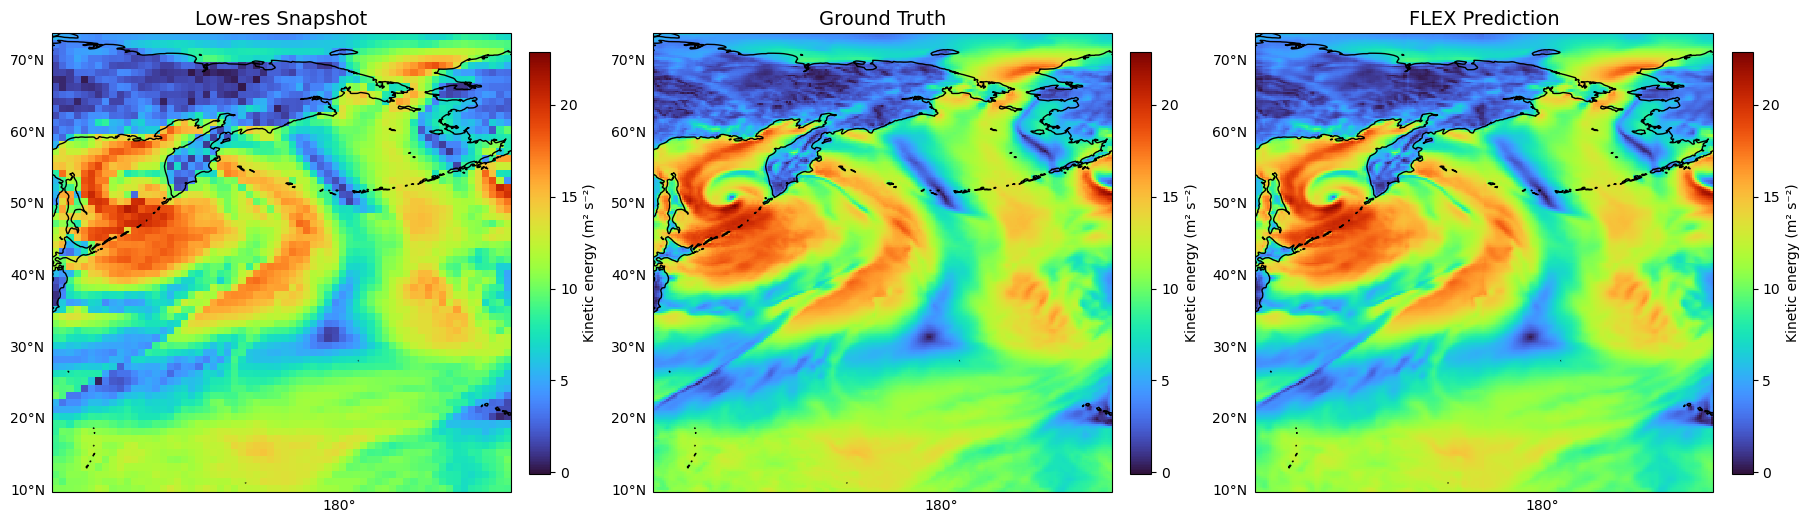

In [10]:
plot_results(conditioning_snapshots=conditioning_snapshots, targets=targets, dm_predictions=dm_predictions)

### Relative Error

Once we have a stitched, high-resolution prediction we need a single number that tells us how far it strays from reality.  
A simple and widely used choice is the Relative Frobenius-Norm Error (RFNE):

In [11]:
relative_error = np.linalg.norm(targets-dm_predictions) / np.linalg.norm(targets)
print(f'The relative error is {relative_error*100} %')

The relative error is 1.2361346770409778 %


> **The RFNE answers:**  
> *“What fraction of the true kinetic-energy magnitude is missing or misplaced in our reconstruction?”*

| RFNE value | Interpretation |
|-----------:|----------------|
| **0 .0** | perfect match |
| **0 .1** (10 %) | excellent — only a tenth of the energy is mis-located |
| **> 1 .0** (100 %) | worse than predicting all zeros! |


### Why not use MSE?  
*Squared errors scale with the variable’s physical unit, making cross-case comparison tricky.*  **RFNE** is **scale-invariant** and directly interpretable as the percentage of energy mis-represented.



### Power Spectrum

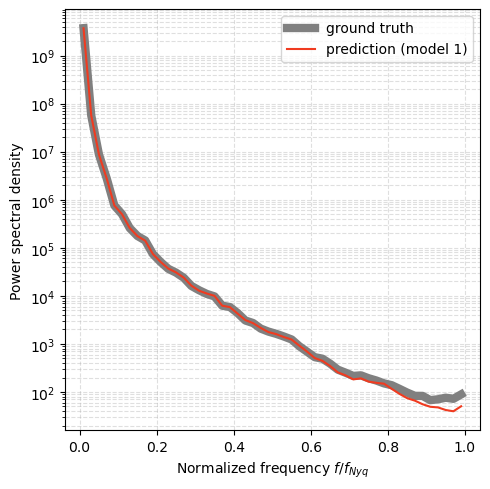

In [12]:
plot_reduced_spectrum(targets[0,0,:,:], dm_predictions[0,0,:,:], nbins=50)

### Uncertainty Quantification

**Idea ↦ Confidence.** Instead of trusting a single super-resolved image, we run the sampler **_N_ independent times**, stack the resulting fields, and compute:

* **Mean prediction** – our best estimate.  
* **σ-map (standard deviation)** – a pixel-wise measure of how much the ensemble disagrees.

Bright regions in the σ-map flag areas where multiple fine-scale patterns are equally plausible given the coarse ERA5 input, while dark regions indicate high confidence. Evaluating both the mean error and this spread tells us not only **how accurate** the model is, but also **how honest** it is about its own uncertainty.


In [13]:
std = stich(std.detach().cpu().numpy()).reshape(1,1,256,256)

Text(0.5, 1.0, 'Uncertainty Estimates')

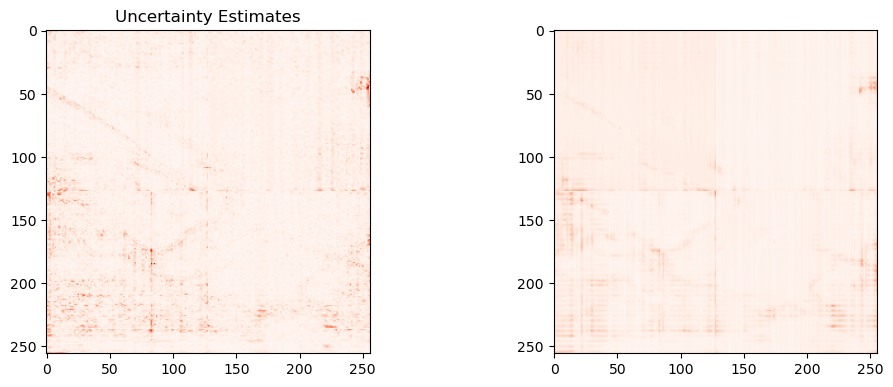

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4.2))

axes[0].imshow(np.abs(targets-dm_predictions)[0,0,:,:], cmap='Reds')
axes[0].set_title('Absolute Errors')
axes[1].imshow(std[0,0,:,:], cmap='Reds', vmin=0, vmax=2)
axes[0].set_title('Uncertainty Estimates')

## Assessing Uncertainty with the **Pull Distribution**

When a diffusion model (or any probabilistic regressor) returns both  

* a **mean** prediction $\hat{x}$ and  
* an **aleatoric** standard-deviation estimate $\hat{\sigma}$,

we can check how well-calibrated those uncertainties are by forming the **pull** (sometimes called a *z-score*):

$$
z \;=\; \frac{\hat{x}-x}{\hat{\sigma}},
$$

where  $x$ is the ground-truth target. If the model’s predictive distribution is
**perfectly calibrated** *and* the residuals are Gaussian, then

$$
z \sim \mathcal{N}\!\bigl(0,\,1\bigr).
$$

So—in an ideal world—the histogram of all pull values should follow the
standard normal bell curve.  Fitting a Gaussian to that histogram gives two key
summary numbers:

* **Empirical mean** $\mu$
* **Empirical width (standard deviation)** $\sigma_{\text{pull}}$

---

### How to read the fitted parameters

| Statistic | What you want | What it means if it drifts |
|-----------|---------------|----------------------------|
| $\mu \approx 0$ | unbiased predictions | *$\mu > 0$* → systematic **over-prediction** (predictions too high).<br>*$\mu < 0$* → systematic **under-prediction**. |
| $\sigma_{\text{pull}} \approx 1$ | well-calibrated spread | *$\sigma_{\text{pull}} > 1$* → **over-confidence**: the model’s $\hat{\sigma}$ are too small; real errors spread wider than claimed.<br>*$\sigma_{\text{pull}} < 1$* → **under-confidence**: the model’s $\hat{\sigma}$ are too large; real errors are tighter than claimed. |

> **Rule-of-thumb for “good” calibration**  
> $$
 |\mu| \lesssim 0.05 \quad\text{and}\quad 0.9 \le \sigma_{\text{pull}} \le 1.1.
 $$


μ̂ = -0.60,  σ̂ = 1.73


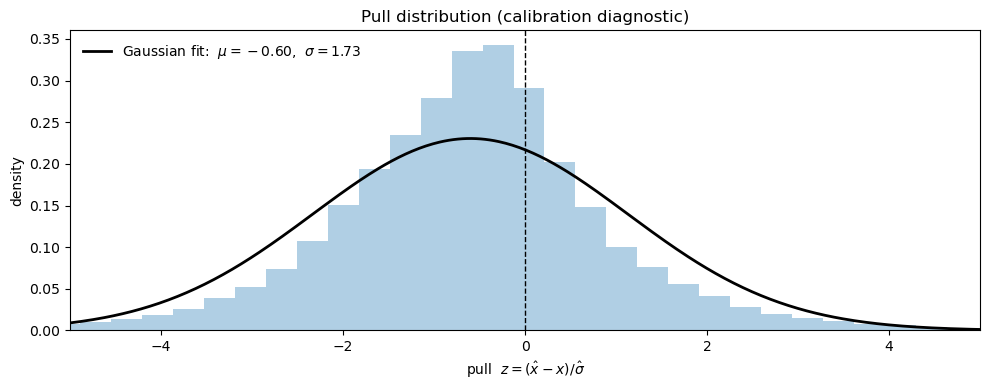

In [15]:
mu_hat, sigma_hat = plot_pull(
    dm_predictions[0, 0],
    targets[0, 0],
    std[0, 0],
    bins=200,
    clip=5.0,
)
print(f"μ̂ = {mu_hat:+.2f},  σ̂ = {sigma_hat:.2f}")